# Model Training

## Setup

In [823]:
pip install segmentation_models_pytorch

Note: you may need to restart the kernel to use updated packages.


In [824]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, cohen_kappa_score
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F
import rasterio
from PIL import Image
from torchvision.models.segmentation import deeplabv3_resnet50
import segmentation_models_pytorch as smp
import cv2
import torch.nn as nn
import torch.optim as optim
import torchvision.models as tvm
import matplotlib.pyplot as plt

In [825]:
# set seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Select tiles

In [826]:
# Load metadata and counts
meta = pd.read_csv("../satellite_image/tiles_metadata.csv")
counts = pd.read_csv("../satellite_image/tiles_proportion.csv")

selected_tiles = []

for _, row in counts.iterrows():
    county = row['county']
    n_pos = row['with_solar']
    n_neg = row['nb_nopv']
    augment = row['transformation']

    pos_candidates = meta[(meta.county== county) & (meta.label == 1)]
    neg_candidates = meta[(meta.county== county) & (meta.label== 0)]

    pos_sample = pos_candidates.sample(n=min(len(pos_candidates), n_pos), random_state=seed)
    neg_sample = neg_candidates.sample(n=min(len(neg_candidates), n_neg), random_state=seed)

    pos_sample['augment'] = augment
    neg_sample['augment'] = False  # no augmentation for negatives

    selected_tiles.append(pd.concat([pos_sample, neg_sample]))

df_selected = pd.concat(selected_tiles).reset_index(drop=True)

In [827]:
df_selected.head()

,tile_path,mask_path,county,label,augment
0,D:\solar-data-china\tiles\Augmented_with_indic...,D:\solar-data-china\tiles\Augmented_mask\s2_Zh...,Augmented,1,False
1,D:\solar-data-china\tiles\Augmented_with_indic...,D:\solar-data-china\tiles\Augmented_mask\s2_Xi...,Augmented,1,False
2,D:\solar-data-china\tiles\Augmented_with_indic...,D:\solar-data-china\tiles\Augmented_mask\s2_Zh...,Augmented,1,False
3,D:\solar-data-china\tiles\Augmented_with_indic...,D:\solar-data-china\tiles\Augmented_mask\s2_Na...,Augmented,1,False
4,D:\solar-data-china\tiles\Augmented_with_indic...,D:\solar-data-china\tiles\Augmented_mask\s2_Na...,Augmented,1,False


In [828]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tile_path  783 non-null    object
 1   mask_path  783 non-null    object
 2   county     783 non-null    object
 3   label      783 non-null    int64 
 4   augment    783 non-null    bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 25.4+ KB


## Split into train/validation/test

In [829]:
train_val, test = train_test_split(
    df_selected, test_size=0.15, random_state=seed
)

train, val = train_test_split(
    train_val, test_size=0.15,  random_state=seed
)

train['split'] = 'train'
val['split'] = 'val'
test['split'] = 'test'

df_final = pd.concat([train, val, test]).reset_index(drop=True)

df_final.to_csv("dataset_split.csv", index=False)

In [830]:
df_final

,tile_path,mask_path,county,label,augment,split
0,D:\solar-data-china\tiles\Xuanhua_with_indices...,D:\solar-data-china\tiles\Xuanhua_mask\s2_Xuan...,Xuanhua,1,False,train
1,D:\solar-data-china\tiles\Heshui_with_indices\...,D:\solar-data-china\tiles\Heshui_mask\s2_Heshu...,Heshui,0,False,train
2,D:\solar-data-china\tiles\Gushi_with_indices\s...,D:\solar-data-china\tiles\Gushi_mask\s2_Gushi-...,Gushi,1,True,train
3,D:\solar-data-china\tiles\Xuanhua_with_indices...,D:\solar-data-china\tiles\Xuanhua_mask\s2_Xuan...,Xuanhua,1,False,train
4,D:\solar-data-china\tiles\LanpingBaiandPumi_wi...,D:\solar-data-china\tiles\LanpingBaiandPumi_ma...,LanpingBaiandPumi,0,False,train
...,...,...,...,...,...,...
778,D:\solar-data-china\tiles\Gushi_with_indices\s...,D:\solar-data-china\tiles\Gushi_mask\s2_Gushi-...,Gushi,1,True,test
779,D:\solar-data-china\tiles\Augmented_with_indic...,D:\solar-data-china\tiles\Augmented_mask\s2_Li...,Augmented,1,False,test
780,D:\solar-data-china\tiles\Gushi_with_indices\s...,D:\solar-data-china\tiles\Gushi_mask\s2_Gushi-...,Gushi,0,False,test
781,D:\solar-data-china\tiles\Shuangfeng_with_indi...,D:\solar-data-china\tiles\Shuangfeng_mask\s2_S...,Shuangfeng,0,False,test


In [831]:
print("Train samples:", (df_final['split'] == 'train').sum())
print("Validation samples:", (df_final['split'] == 'val').sum())
print("Test samples:", (df_final['split'] == 'test').sum())


Train samples: 565
Validation samples: 100
Test samples: 118


## Dataset & Augmentation

In [832]:
# Check how many bands the first image has
sample_img_path = df_final.iloc[0]['tile_path']
with rasterio.open(sample_img_path) as src:
    num_bands = src.count
print(f"Number of bands in the sample image: {num_bands}")


Number of bands in the sample image: 12


In [833]:
class SolarDataset(Dataset):
    def __init__(self, df, target_size=(256, 256), transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['tile_path']
        mask_path = row['mask_path']

        # Read image (12 bands)
        with rasterio.open(img_path) as src:
            img_np = src.read(list(range(1, 13))).astype(np.float32)  # [C, H, W]
            img_np = np.transpose(img_np, (1, 2, 0))  # [H, W, C]

        # Valid mask: 1 where all bands valid, 0 where NaN
        valid_mask = (~np.isnan(img_np)).all(axis=2).astype(np.uint8)
        img_np = np.nan_to_num(img_np, nan=0.0)

        # Read ground truth mask
        with rasterio.open(mask_path) as src_mask:
            gt_mask_np = src_mask.read(1).astype(np.uint8)

        # Validate shape consistency
        if gt_mask_np.shape != valid_mask.shape:
            raise ValueError(f"Shape mismatch at idx {idx}: gt_mask {gt_mask_np.shape} vs valid_mask {valid_mask.shape}")

        # Apply valid mask
        img_np = img_np * valid_mask[..., None]
        gt_mask_np = gt_mask_np * valid_mask

        # Stack masks (gt_mask and valid_mask)
        combined_masks_np = np.stack([gt_mask_np, valid_mask], axis=-1)

        # Apply augmentation if provided and augment flag is True
        if self.transform is not None and bool(row.get('augment', False)):
            img_np, combined_masks_np = self.transform(img_np, combined_masks_np)

        # Convert to torch tensors and transpose to [C, H, W]
        img_tensor = torch.from_numpy(img_np.transpose(2, 0, 1))  # [12, H, W]
        masks_tensor = torch.from_numpy(combined_masks_np.transpose(2, 0, 1)).float()  # [2, H, W]

        # Resize to target size
        img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=self.target_size, mode='bilinear', align_corners=False).squeeze(0)
        masks_tensor = F.interpolate(masks_tensor.unsqueeze(0), size=self.target_size, mode='nearest').squeeze(0)

        # Verify masks tensor shape
        if masks_tensor.shape[0] != 2:
            raise ValueError(f"Mask tensor does not have 2 channels after resizing, got shape {masks_tensor.shape}")

        # Prepare final masks
        final_gt_mask = (masks_tensor[0:1] > 0).float()
        final_loss_mask = (masks_tensor[1:2] >= 0.5).float()

        final_masks = torch.cat([final_gt_mask, final_loss_mask], dim=0)  # [2, H, W]

        # Normalize image tensor
        img_tensor = img_tensor / 255.0

        return img_tensor, final_masks

In [834]:
# Ensure input is numpy (H, W, C)
def ensure_numpy(x):
    """Convert PIL or torch tensor to numpy array, shape (H, W, C)."""
    if isinstance(x, Image.Image):
        x = np.array(x)
    if isinstance(x, torch.Tensor):
        x = x.permute(1, 2, 0).cpu().numpy()
    if x.ndim == 3 and x.shape[0] in (12, 13) and x.shape[0] < x.shape[1]:
        x = np.transpose(x, (1, 2, 0))
    if x.ndim == 2:  # mask
        x = x[..., None]
    return x


# Base class for all transforms
class BaseTransform:
    def __call__(self, img, mask):
        raise NotImplementedError


# Resize to standard size
class Resize12Bands(BaseTransform):
    """Resize image and mask to a fixed size."""
    def __init__(self, size):
        self.size = size  # (H, W)

    def __call__(self, img, mask):
        img, mask = ensure_numpy(img), ensure_numpy(mask)

        # Resize image (each band)
        img_resized = np.stack([
            cv2.resize(img[..., i], self.size[::-1], interpolation=cv2.INTER_LINEAR)
            for i in range(img.shape[2])
        ], axis=-1)

        # Resize mask (nearest neighbor)
        mask_resized = cv2.resize(mask[..., 0], self.size[::-1], interpolation=cv2.INTER_NEAREST)[..., None]
        return img_resized, mask_resized


# Random horizontal flip (left-right), probability p
class RandomHorizontalFlip12Bands(BaseTransform):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        img, mask = ensure_numpy(img), ensure_numpy(mask)
        if np.random.rand() < self.p:
            img = np.flip(img, axis=1).copy()
            mask = np.flip(mask, axis=1).copy()
        return img, mask


# Random vertical flip (up-down), probability p
class RandomVerticalFlip12Bands(BaseTransform):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        img, mask = ensure_numpy(img), ensure_numpy(mask)
        if np.random.rand() < self.p:
            img = np.flip(img, axis=0).copy()
            mask = np.flip(mask, axis=0).copy()
        return img, mask


# Random rotation by up to ±degrees
class RandomRotation12Bands(BaseTransform):
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, img, mask):
        img, mask = ensure_numpy(img), ensure_numpy(mask)
        angle = np.random.uniform(-self.degrees, self.degrees)
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)

        # Rotate each band & mask
        img_rotated = np.stack([
            cv2.warpAffine(img[..., i], M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
            for i in range(img.shape[2])
        ], axis=-1)

        mask_rotated = cv2.warpAffine(mask[..., 0], M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)[..., None]
        return img_rotated, mask_rotated


# Random affine transformation: combines rotation, translation, scaling, shearing
class RandomAffine12Bands(BaseTransform):
    def __init__(self, degrees=0, translate=(0,0), scale=(1,1), shear=0):
        self.degrees = degrees
        self.translate = translate
        self.scale = scale
        self.shear = shear

    def __call__(self, img, mask):
        img, mask = ensure_numpy(img), ensure_numpy(mask)
        h, w = img.shape[:2]
        center = np.array([w/2, h/2])

        # Sample random parameters
        angle = np.random.uniform(-self.degrees, self.degrees)
        scale_factor = np.random.uniform(*self.scale)
        shear_deg = np.random.uniform(-self.shear, self.shear)
        tx = np.random.uniform(-self.translate[0], self.translate[0]) * w
        ty = np.random.uniform(-self.translate[1], self.translate[1]) * h

        # Build affine matrix
        angle_rad = np.radians(angle)
        shear_rad = np.radians(shear_deg)

        rot_scale = np.array([
            [np.cos(angle_rad), -np.sin(angle_rad)],
            [np.sin(angle_rad),  np.cos(angle_rad)]
        ]) * scale_factor

        shear_mat = np.array([[1, np.tan(shear_rad)], [0, 1]])
        affine_mat = rot_scale @ shear_mat

        M = np.hstack([affine_mat, [[0], [0]]])
        M[:,2] += center - affine_mat @ center + np.array([tx, ty])

        # Apply to each band and mask
        img_out = np.stack([
            cv2.warpAffine(img[..., i], M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
            for i in range(img.shape[2])
        ], axis=-1)

        mask_out = cv2.warpAffine(mask[..., 0], M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)[..., None]
        return img_out, mask_out


# Slightly blur the image (simulates defocus, noise)
class GaussianBlur12Bands(BaseTransform):
    def __init__(self, kernel_size=3, sigma=(0.1, 2.0)):
        # Ensure odd kernel size >= 3
        self.kernel_size = max(3, kernel_size | 1)
        self.sigma = sigma

    def __call__(self, img, mask):
        img, mask = ensure_numpy(img), ensure_numpy(mask)
        sigma_val = np.random.uniform(*self.sigma)

        img_out = np.stack([
            cv2.GaussianBlur(img[..., i], (self.kernel_size, self.kernel_size), sigmaX=sigma_val, sigmaY=sigma_val, borderType=cv2.BORDER_REFLECT_101)
            for i in range(img.shape[2])
        ], axis=-1)
        return img_out, mask


# Randomly erase a rectangle (simulates occlusion, similar to Cutout)
class RandomErasing12Bands(BaseTransform):
    def __init__(self, p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)):
        self.p = p
        self.scale = scale
        self.ratio = ratio

    def __call__(self, img, mask):
        img, mask = ensure_numpy(img), ensure_numpy(mask)
        if np.random.rand() > self.p:
            return img, mask

        h, w = img.shape[:2]
        area = h * w

        target_area = np.random.uniform(*self.scale) * area
        aspect_ratio = np.random.uniform(*self.ratio)

        erase_h = int(np.sqrt(target_area / aspect_ratio))
        erase_w = int(np.sqrt(target_area * aspect_ratio))

        if erase_h < h and erase_w < w:
            y1 = np.random.randint(0, h - erase_h)
            x1 = np.random.randint(0, w - erase_w)
            for i in range(img.shape[2]):
                img[y1:y1+erase_h, x1:x1+erase_w, i] = np.random.uniform(0, 255)
        return img, mask


# Convert image and mask to PyTorch tensors
class ToTensor12Bands(BaseTransform):
    def __call__(self, img, mask):
        img, mask = ensure_numpy(img), ensure_numpy(mask)

        # Normalize image to [0,1] and permute to (C,H,W)
        img_tensor = torch.from_numpy(img.transpose(2, 0, 1).astype(np.float32) / 255.0)

        # Mask stays integer, shape (H,W)
        mask_tensor = torch.from_numpy(mask[...,0].astype(np.int64))

        return img_tensor, mask_tensor


# Compose several transforms
class Compose12Bands:
    """Apply a sequence of transforms to (img, mask)."""
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        for t in self.transforms:
            img, mask = t(img, mask)
        return img, mask


# Base transform: only resize and convert to tensor
base_transform = Compose12Bands([])

# Augmented transform: with random flips, rotations, affine, blur, erasing
aug_transform = Compose12Bands([
    RandomHorizontalFlip12Bands(),
    RandomVerticalFlip12Bands(),
    RandomRotation12Bands(degrees=30),  # random rotation by ±30°
    RandomAffine12Bands(
        degrees=15,                    # rotate by ±15°
        translate=(0.1, 0.1),          # translate up to 10% x & y
        scale=(0.9, 1.1),              # scale 90–110%
        shear=10                       # shear up to ±10°
    ),
    GaussianBlur12Bands(kernel_size=3, sigma=(0.1, 2.0)),
    RandomErasing12Bands(
        p=0.5,                        # apply with 50% chance
        scale=(0.02, 0.2),            # erase area 2–20% of image
        ratio=(0.3, 3.3)              # aspect ratio of erased rectangle
    )
])

transforms_dict = {
    'base': base_transform,
    'aug': aug_transform
}

In [835]:
# Create dataloaders
train_ds = SolarDataset(df_final[df_final['split'] == 'train'], transform=transforms_dict['aug'])
val_ds   = SolarDataset(df_final[df_final['split'] == 'val'], transform=transforms_dict['base'])
test_ds  = SolarDataset(df_final[df_final['split'] == 'test'], transform=transforms_dict['base'])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=8, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=8, drop_last=False)


## Model & Training

### Initialize model, loss, optimizer, scheduler

In [836]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [837]:
def get_resnet34_unet_12bands():
    # Create SMP Unet with ResNet34 encoder, no weights (random init), 12 input channels
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights=None,
        in_channels=12, 
        classes=1
    )

    # Load torchvision pretrained ResNet34
    tv_resnet = tvm.resnet34(weights=tvm.ResNet34_Weights.IMAGENET1K_V1)
    pretrained_conv1 = tv_resnet.conv1  # [64, 3, 7, 7]

    # Find the first conv layer in SMP model
    # usually model.encoder has a ._modules['0'] or similar
    encoder_conv1 = None
    for m in model.encoder.modules():
        if isinstance(m, torch.nn.Conv2d) and m.in_channels == 12:
            encoder_conv1 = m
            break
    if encoder_conv1 is None:
        raise RuntimeError("Could not find encoder conv1 with 12 input channels")

    with torch.no_grad():
        # initialize weights
        new_weight = torch.zeros_like(encoder_conv1.weight)

        # copy RGB weights
        new_weight[:, :3, :, :] = pretrained_conv1.weight

        # average RGB weights for other 9 channels
        mean_rgb = pretrained_conv1.weight.mean(dim=1, keepdim=True)  # [64,1,7,7]
        new_weight[:, 3:, :, :] = mean_rgb.repeat(1, 9, 1, 1)

        encoder_conv1.weight.copy_(new_weight)

    return model


In [838]:
model = get_resnet34_unet_12bands().to(device)

### Loss & Optimizer

In [839]:
criterion = nn.BCEWithLogitsLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=5
)

### Metrics

In [840]:
def compute_metrics(outputs, targets, threshold=0.5):
    """
    Computes a suite of classification metrics for binary classification.

    Returns:
        acc: Overall accuracy (OA)
        f1: F1 score
        kappa: Cohen's kappa coefficient
        prod_acc: Producer's accuracy (recall for positive class)
        user_acc: User's accuracy (precision for positive class)
        conf_mat: Confusion matrix (2x2)
    """
    # Apply sigmoid and threshold to get binary predictions
    preds = (torch.sigmoid(outputs) > threshold)

    # Flatten and convert to numpy uint8 arrays
    preds_np = preds.cpu().numpy().astype(np.uint8).flatten()
    targets_np = targets.cpu().numpy().astype(np.uint8).flatten()

    # Confusion matrix: [[TN, FP], [FN, TP]] - pass labels explicitly
    conf_mat = confusion_matrix(targets_np, preds_np, labels=[0, 1])

    # Overall accuracy (OA) - pass labels to keep consistent shape if needed
    acc = accuracy_score(targets_np, preds_np)

    # F1 score with zero_division=1 to avoid errors when no positive predictions
    f1 = f1_score(targets_np, preds_np, labels=[0, 1], zero_division=1)

    # Cohen's kappa coefficient
    kappa = cohen_kappa_score(targets_np, preds_np, labels=[0, 1])

    # Producer's accuracy: TP / (TP + FN) = recall for positive class
    # User's accuracy: TP / (TP + FP) = precision for positive class
    TP = conf_mat[1, 1]
    FN = conf_mat[1, 0]
    FP = conf_mat[0, 1]

    prod_acc = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    user_acc = TP / (TP + FP) if (TP + FP) > 0 else 0.0

    return {
        "overall_accuracy": acc,
        "f1": f1,
        "kappa": kappa,
        "producers_accuracy": prod_acc,
        "users_accuracy": user_acc,
        "confusion_matrix": conf_mat
    }


### Early stopping

In [841]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model, path):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model, path)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
                print("\n")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model, path)
            self.counter = 0

    def save_checkpoint(self, model, path):
        torch.save(model.state_dict(), path)
        if self.verbose:
            print(f"Saved best model to {path}")
            print("\n")

### Training & Testing function

In [842]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_acc, all_f1, all_kappa, all_prod_acc, all_user_acc = [], [], [], [], []

    for images, masks in loader:
        images = images.to(device)          # [B, 12, H, W]
        masks = masks.to(device)            # [B, 2, H, W]

        gt_mask = masks[:, 0:1, :, :]      # Ground truth mask [B,1,H,W]
        loss_mask = masks[:, 1:2, :, :]    # Loss mask [B,1,H,W]

        optimizer.zero_grad()
        outputs = model(images)             # Model output shape e.g. [B, 1, H, W]

        # Ensure outputs have channel dim
        if outputs.dim() == 3:
            outputs = outputs.unsqueeze(1)  # [B, 1, H, W]

        # Calculate loss only over valid pixels indicated by loss_mask
        loss = criterion(outputs, gt_mask)
        masked_loss = loss * loss_mask
        final_loss = masked_loss.sum() / loss_mask.sum().clamp(min=1)

        final_loss.backward()
        optimizer.step()

        running_loss += final_loss.item() * images.size(0)

        # Compute metrics on raw outputs and ground truth masks
        metrics = compute_metrics(outputs.detach(), gt_mask.detach())
        all_acc.append(metrics["overall_accuracy"])
        all_f1.append(metrics["f1"])
        all_kappa.append(metrics["kappa"])
        all_prod_acc.append(metrics["producers_accuracy"])
        all_user_acc.append(metrics["users_accuracy"])

    epoch_loss = running_loss / len(loader.dataset)
    return (epoch_loss, 
            np.mean(all_acc), np.mean(all_f1), np.mean(all_kappa), 
            np.mean(all_prod_acc), np.mean(all_user_acc))


In [843]:
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_acc, all_f1, all_kappa, all_prod_acc, all_user_acc = [], [], [], [], []

    with torch.no_grad():
        for images, masks, loss_masks in loader:
            images, masks, loss_masks = images.to(device), masks.to(device), loss_masks.to(device)

            outputs = model(images)

            # Handle output shape differences if any (e.g., output might have an extra channel dim)
            if outputs.shape != masks.shape:
                outputs = outputs.squeeze(1)

            # Compute per-pixel loss
            loss = criterion(outputs, masks)

            # Apply loss mask and normalize over valid pixels only
            masked_loss = loss * loss_masks
            final_loss = masked_loss.sum() / loss_masks.sum().clamp(min=1)

            running_loss += final_loss.item() * images.size(0)

            metrics = compute_metrics(outputs, masks)
            all_acc.append(metrics["overall_accuracy"])
            all_f1.append(metrics["f1"])
            all_kappa.append(metrics["kappa"])
            all_prod_acc.append(metrics["producers_accuracy"])
            all_user_acc.append(metrics["users_accuracy"])

    epoch_loss = running_loss / len(loader.dataset)
    return (epoch_loss, np.mean(all_acc), np.mean(all_f1), np.mean(all_kappa), 
            np.mean(all_prod_acc), np.mean(all_user_acc))

In [844]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    early_stopping = EarlyStopping(patience=10, verbose=True)

    train_acc_history = []
    val_acc_history = []
    train_f1_history = []
    val_f1_history = []
    train_loss_history = []
    val_loss_history = []
    train_kappa_history = []
    val_kappa_history = []
    train_prod_acc_history = []
    val_prod_acc_history = []
    train_user_acc_history = []
    val_user_acc_history = []

    for epoch in range(1, epochs+1):
        # Adapted to new output of train_one_epoch (returns 6 metrics)
        train_loss, train_acc, train_f1, train_kappa, train_prod_acc, train_user_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc, val_f1, val_kappa, val_prod_acc, val_user_acc = eval_one_epoch(
            model, val_loader, criterion, device
        )

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        train_f1_history.append(train_f1)
        val_f1_history.append(val_f1)
        train_kappa_history.append(train_kappa)
        val_kappa_history.append(val_kappa)
        train_prod_acc_history.append(train_prod_acc)
        val_prod_acc_history.append(val_prod_acc)
        train_user_acc_history.append(train_user_acc)
        val_user_acc_history.append(val_user_acc)

        scheduler.step(val_loss)

        print(f"Epoch {epoch}/{epochs}:\n"
              f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f} | "
              f"Kappa: {train_kappa:.4f} | Prod Acc: {train_prod_acc:.4f} | User Acc: {train_user_acc:.4f}\n"
              f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f} | "
              f"Kappa: {val_kappa:.4f} | Prod Acc: {val_prod_acc:.4f} | User Acc: {val_user_acc:.4f}\n"
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        early_stopping(val_loss, model, "best_model.pth")

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    model.load_state_dict(torch.load("best_model.pth"))
    return (
        model,
        train_acc_history, val_acc_history,
        train_f1_history, val_f1_history,
        train_loss_history, val_loss_history,
        train_kappa_history, val_kappa_history,
        train_prod_acc_history, val_prod_acc_history,
        train_user_acc_history, val_user_acc_history
    )


In [845]:
def test_model(model, test_loader, criterion, device):
    test_loss, test_acc, test_f1, test_kappa, test_prod_acc, test_user_acc = eval_one_epoch(model, test_loader, criterion, device)
    print(f"Test Results:\n Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | F1: {test_f1:.4f} | Kappa: {test_kappa:.4f} | Prod Acc: {test_prod_acc:.4f} | User Acc: {test_user_acc:.4f}")

### Main 

In [846]:
EPOCH = 50

In [847]:
if __name__ == "__main__":
    (
        model,
        train_acc_history, val_acc_history,
        train_f1_history, val_f1_history,
        train_loss_history, val_loss_history,
        train_kappa_history, val_kappa_history,
        train_prod_acc_history, val_prod_acc_history,
        train_user_acc_history, val_user_acc_history
    ) = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, device, EPOCH
    )

    test_model(model, test_loader, criterion, device)

    torch.save(model.state_dict(), "final_model.pth")


ValueError: Mask tensor does not have 2 channels after resizing, got shape torch.Size([1, 256, 256])

In [ ]:
dataset = SolarDataset(df_final,target_size=(256, 256), transform=None)
img, gt_mask = dataset[123]
print(img.shape, gt_mask.shape)


torch.Size([12, 256, 256]) torch.Size([2, 256, 256])


### Analysis

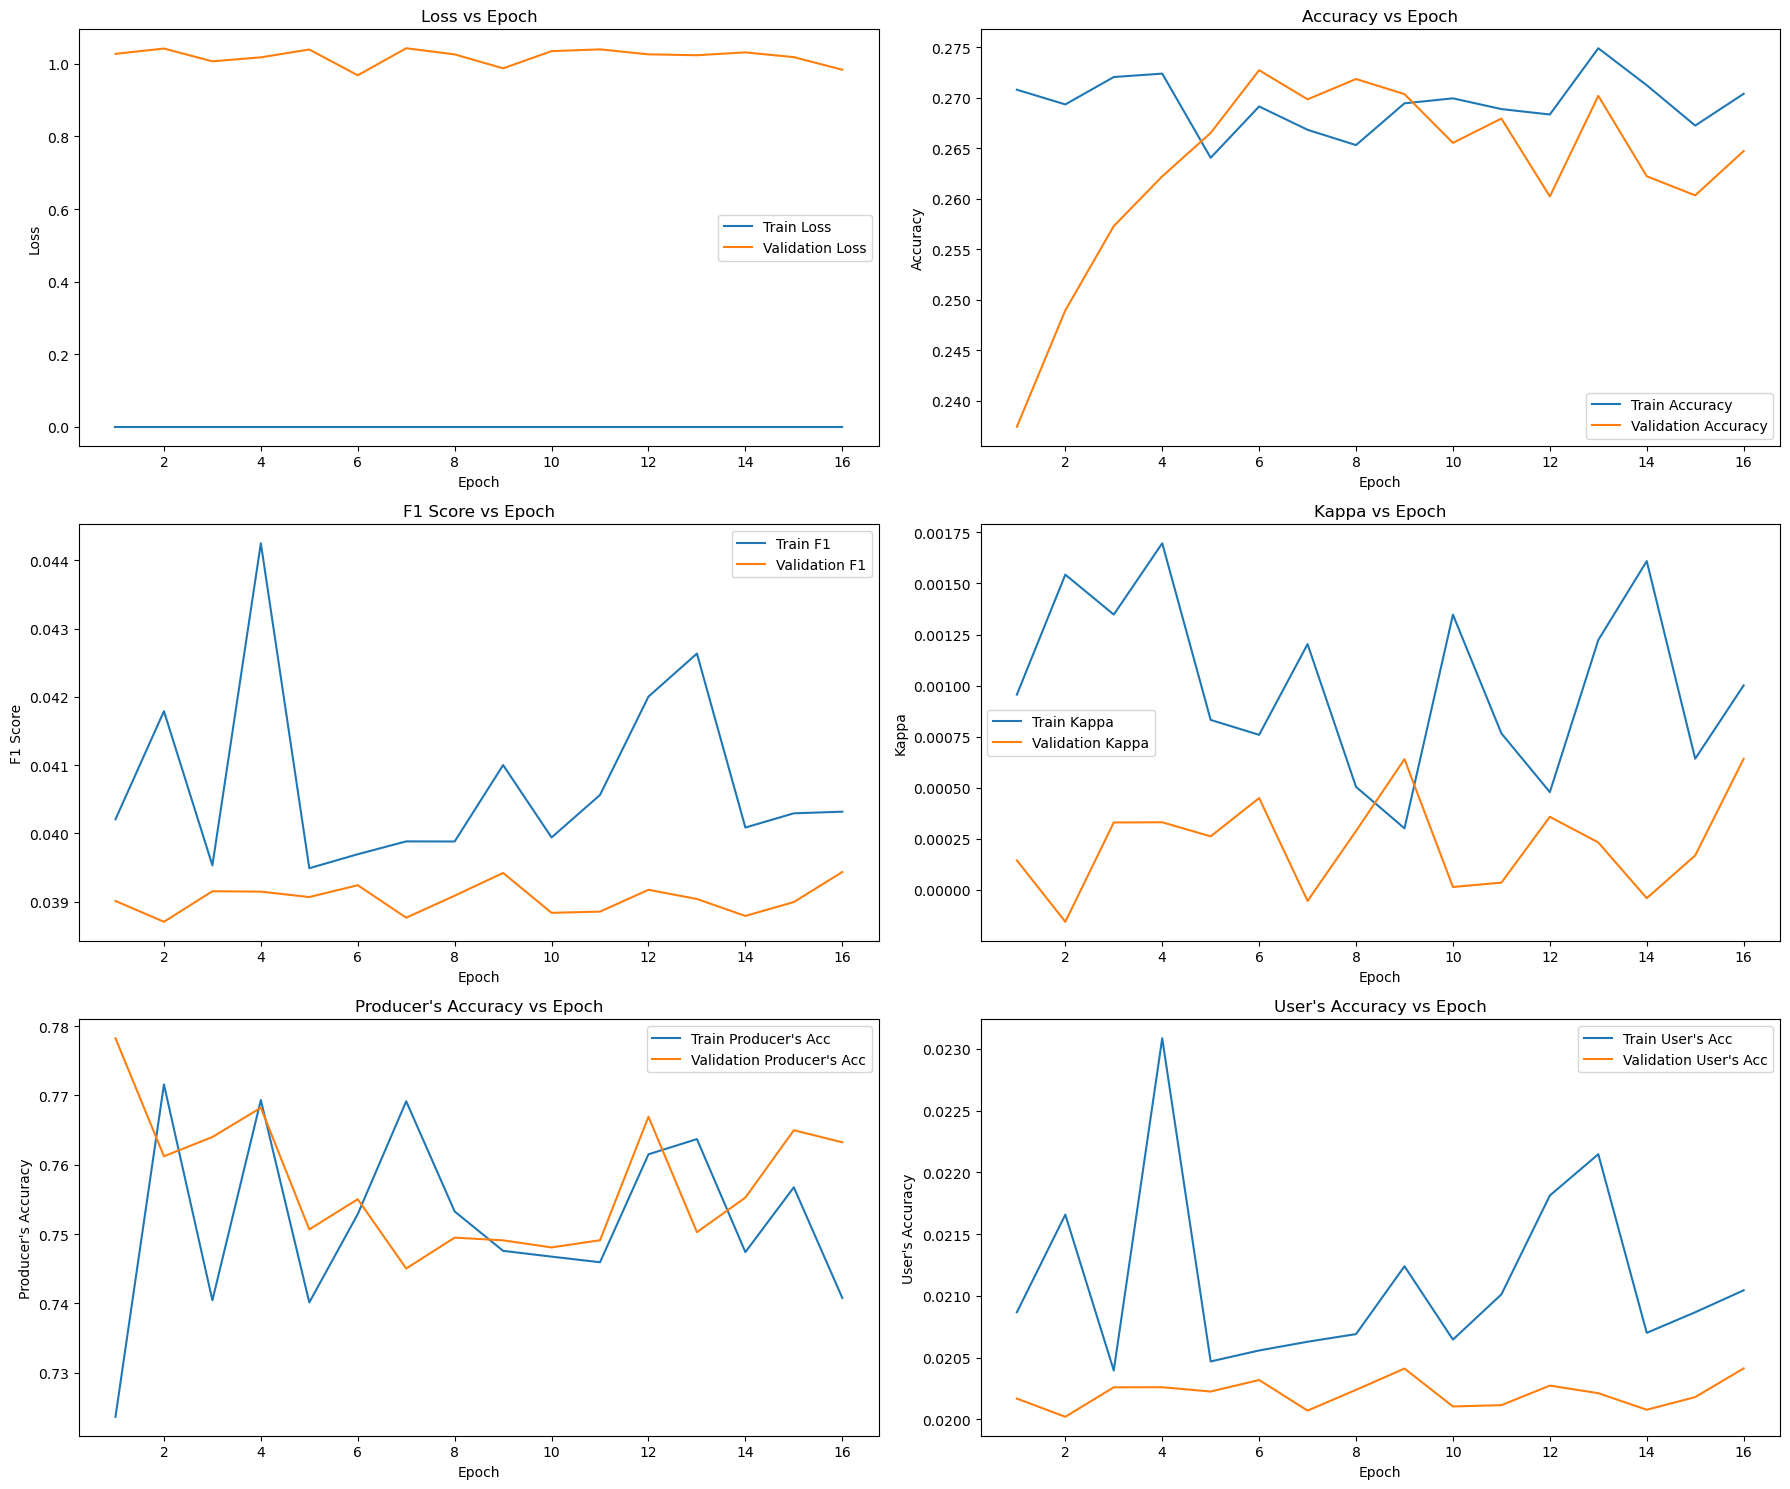

In [ ]:
epochs = range(1, len(train_acc_history) + 1)

plt.figure(figsize=(18, 15))

# Loss
plt.subplot(3, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

# Accuracy
plt.subplot(3, 2, 2)
plt.plot(epochs, train_acc_history, label='Train Accuracy')
plt.plot(epochs, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

# F1 Score
plt.subplot(3, 2, 3)
plt.plot(epochs, train_f1_history, label='Train F1')
plt.plot(epochs, val_f1_history, label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epoch')
plt.legend()

# Kappa
plt.subplot(3, 2, 4)
plt.plot(epochs, train_kappa_history, label='Train Kappa')
plt.plot(epochs, val_kappa_history, label='Validation Kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa')
plt.title('Kappa vs Epoch')
plt.legend()

# Producer's Accuracy
plt.subplot(3, 2, 5)
plt.plot(epochs, train_prod_acc_history, label="Train Producer's Acc")
plt.plot(epochs, val_prod_acc_history, label="Validation Producer's Acc")
plt.xlabel('Epoch')
plt.ylabel("Producer's Accuracy")
plt.title("Producer's Accuracy vs Epoch")
plt.legend()

# User's Accuracy
plt.subplot(3, 2, 6)
plt.plot(epochs, train_user_acc_history, label="Train User's Acc")
plt.plot(epochs, val_user_acc_history, label="Validation User's Acc")
plt.xlabel('Epoch')
plt.ylabel("User's Accuracy")
plt.title("User's Accuracy vs Epoch")
plt.legend()

plt.tight_layout()
plt.show()